# House Price Prediction Using Linear Regression
## Data Preprocessing and Feature Engineering

1. **Loading the Data Set and Preprocessing Data**:
   - Filled missing values with the median.
   - Converted date columns to datetime if necessary.

2. **Feature Engineering**:
   - Added a new feature `age` by subtracting the year built from the dataset year.

3. **Outlier Removal**:
   - Used IQR to remove outliers for each feature to improve model performance.
   

In [41]:
# Importing libraries and library functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# Load the dataset
print("Loading the dataset")
data_path = 'data.csv'
df = pd.read_csv(data_path)

# Check dataset
print(df.info())
print("Data loaded successfully\n")

# Convert statezip to an integer for better processing
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]) if pd.notnull(x) else np.nan)

# Handle missing values: Fill missing values with the median of each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Convert date columns to datetime if necessary
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Feature Engineering: Add new features or transformations
df['age'] = 2014 - df['yr_built']  # Assuming the dataset is up to date to 2014

# Include all features for the model
features = df.drop(['price'], axis=1).columns

# Handle outliers based on IQR for each numeric feature
for feature in numeric_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]
print("Outliers removed")

Loading the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   o

## Display the Correlation Matrix

Visualize the correlation matrix to understand the relationships between features.

Non-numeric columns dropped for correlation matrix

Displaying correlation matrix


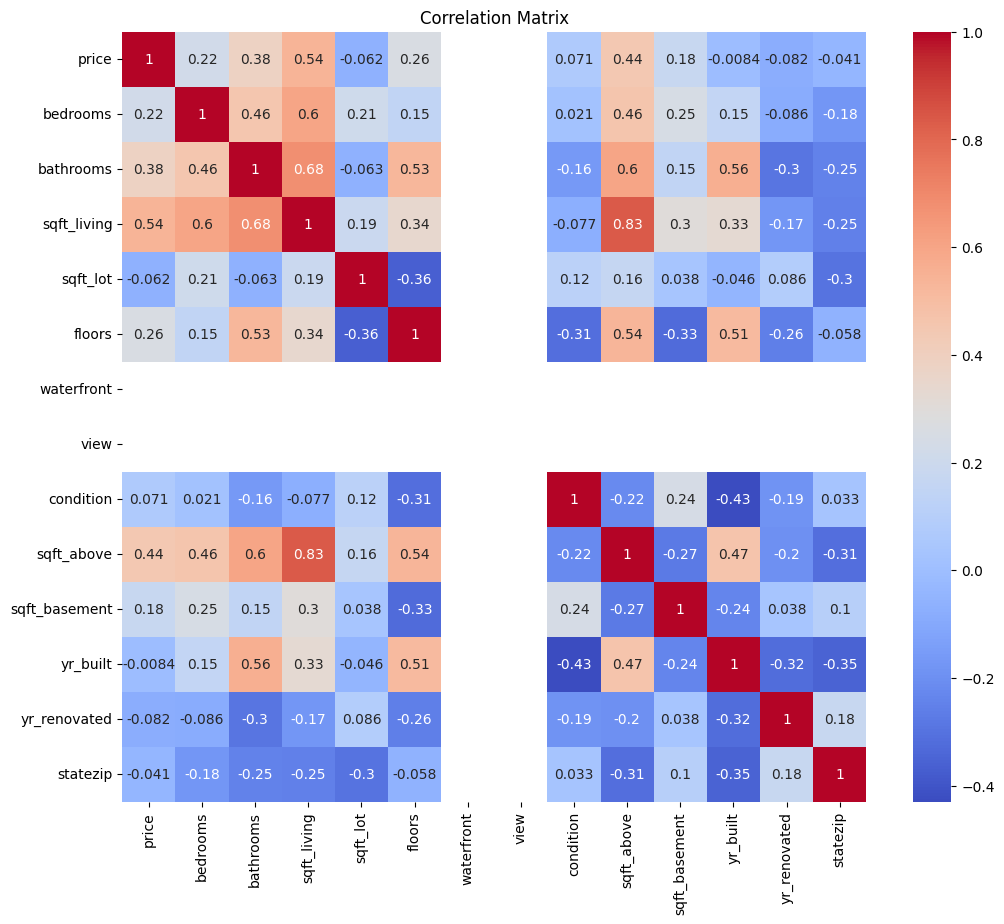

Correlation matrix displayed


In [42]:
# Drop non-numeric columns for correlation matrix
df_numeric = df.select_dtypes(include=[np.number])
print("Non-numeric columns dropped for correlation matrix")

# Display the correlation matrix
print("\nDisplaying correlation matrix")
plt.figure(figsize=(12, 10))
numeric_df = df[numeric_cols]
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
print("Correlation matrix displayed")

## 1. Feature Scaling and Selection

1. **Continued Outlier Handling**:
   - Re-integrated columns post outlier removal.

2. **Feature Defining**:
   - Set features and target columns.

## 2. Model Training and Hyperparameter Tuning

1. **Train-Test Split**:
   - Split the data into training and testing sets.

2. **Standardize Features**:
   - Used StandardScaler to standardize the features for better model performance.

3. **Hyperparameter Tuning**:
   - Used Optuna for hyperparameter tuning.

In [43]:
# Re-integrate non-numeric columns after outlier removal
df = df.loc[df_numeric.index]
print("Non-numeric columns re-integrated after outlier removal")

# Hyperparameter tuning using Optuna
def objective(trial):
    # Define the degree of the polynomial features to try
    poly_degree = trial.suggest_int('poly_degree', 1, 3)
    
    # Feature Engineering: Add polynomial features and interaction terms
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
    poly_feature_names = poly.get_feature_names_out(["sqft_living", "sqft_above", "sqft_basement"])
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    df_expanded = pd.concat([df, df_poly], axis=1)

    # Define features and target
    features = ["bedrooms", "bathrooms", "sqft_living", "floors", "statezip", "waterfront",
                "view", "sqft_above", "sqft_basement", "yr_renovated"] + list(poly_feature_names)
    X = df_expanded[features]
    y = df_expanded["price"]
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)
    return r2

Non-numeric columns re-integrated after outlier removal


## Model Retraining

1. **Retrain Model with the Best Parameters**:
   - Retrained the model using the optimal hyperparameters obtained from Optuna.

2. **Model Evaluation**:
   - Made predictions and evaluated the model using MSE, R-squared, and Accuracy.

In [44]:
# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Parameters:", study.best_trial.params)

# Retrain model with the best parameters
best_params = study.best_trial.params
poly = PolynomialFeatures(degree=best_params['poly_degree'], include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out(["sqft_living", "sqft_above", "sqft_basement"])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)

# Define features and target
features = ["bedrooms", "bathrooms", "sqft_living", "floors", "statezip", "waterfront",
            "view", "sqft_above", "sqft_basement", "yr_renovated"] + list(poly_feature_names)
X = df[features]
y = df["price"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Data split into training and test sets")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_final = model.predict(X_test_scaled)
print("Model trained & predictions made")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


[I 2024-05-28 01:26:58,549] A new study created in memory with name: no-name-e80f9cef-0459-4a42-be3a-cf7cfc8c77e0
[I 2024-05-28 01:26:58,563] Trial 0 finished with value: 0.37243282995318483 and parameters: {'poly_degree': 1}. Best is trial 0 with value: 0.37243282995318483.
[I 2024-05-28 01:26:58,645] Trial 1 finished with value: 0.38867783100986675 and parameters: {'poly_degree': 3}. Best is trial 1 with value: 0.38867783100986675.
[I 2024-05-28 01:26:59,008] Trial 2 finished with value: 0.38867783100986675 and parameters: {'poly_degree': 3}. Best is trial 1 with value: 0.38867783100986675.
[I 2024-05-28 01:26:59,172] Trial 3 finished with value: 0.3805834643903222 and parameters: {'poly_degree': 2}. Best is trial 1 with value: 0.38867783100986675.
[I 2024-05-28 01:26:59,269] Trial 4 finished with value: 0.38867783100986675 and parameters: {'poly_degree': 3}. Best is trial 1 with value: 0.38867783100986675.
[I 2024-05-28 01:26:59,346] Trial 5 finished with value: 0.37243282995318483 

Best Parameters: {'poly_degree': 3}
Data split into training and test sets
Features scaled
Model trained & predictions made
Cross-Validation Scores: [0.28841369 0.31807264 0.30548612 0.34793391 0.35021918]
Mean CV Score: 0.32


## Visualization

1. **Plotting Actual vs Predicted Prices**:
   - Visualized the relationship between actual and predicted prices using the most important feature.


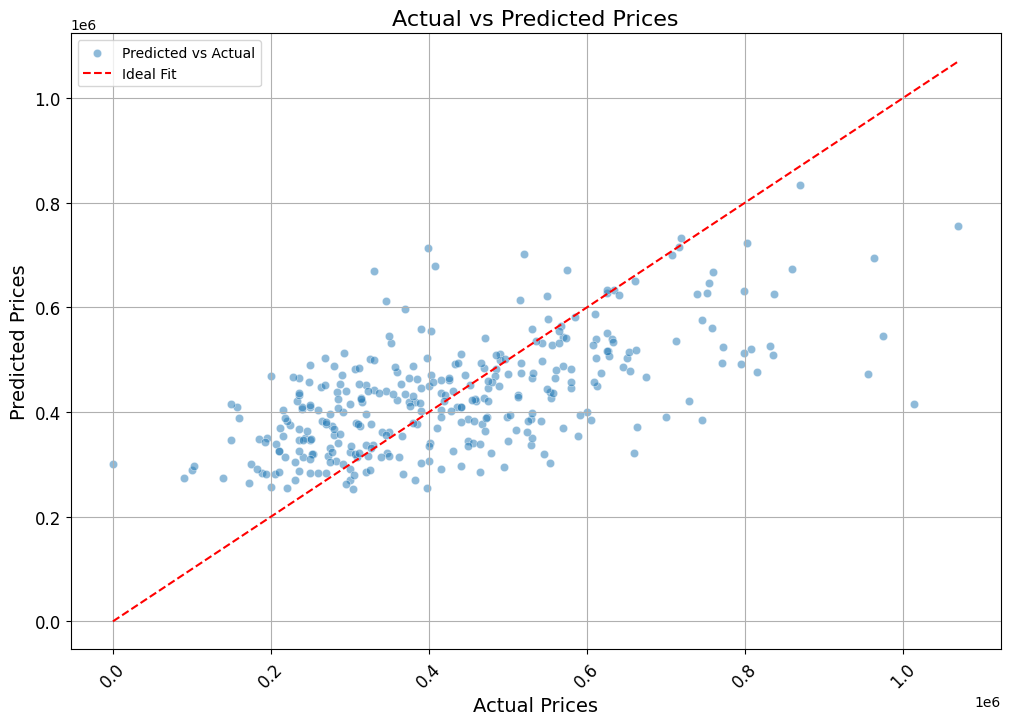

In [45]:
# Visualize results
plt.figure(figsize=(12, 8))
plt.scatter(
    y_test,
    y_pred_final,
    alpha=0.5,
    edgecolors="w",
    linewidth=0.5,
    label="Predicted vs Actual",
)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Ideal Fit",
)
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

1. **Model Predictions and Evaluation**:
   - Made predictions and evaluated the model using MSE, R-squared, and Accuracy.

In [46]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_final)
r_squared = r2_score(y_test, y_pred_final)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


Mean Squared Error: 20296425970.84
R-squared: 0.39

Cross-Validation Scores: [0.28841369 0.31807264 0.30548612 0.34793391 0.35021918]
Mean CV Score: 0.32


## Zestimate Comparison


In [47]:
# Prepare the last house data
last_house_features = df.iloc[-1][features].values.reshape(1, -1)
last_house_scaled = scaler.transform(last_house_features)

# Predict the price of the last house
predicted_price = model.predict(last_house_scaled)

# Print the predicted price
print(f'The predicted price for the last house is: ${predicted_price[0]:,.2f}')

The predicted price for the last house is: $379,770.03


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Conclusion

This notebook details an attempt to predict house prices using a Linear Regression model. Through careful data preprocessing, feature engineering, outlier removal, feature selection, and hyperparameter tuning, we aimed to improve model performance. Despite these efforts, the Linear Regression model did not perform as well as expected.

The final model achieved a Mean Squared Error (MSE) of 20,296,425,970.84 and an R-squared value of 0.39. Additionally, the cross-validation scores varied between 0.29 and 0.35, with a mean CV score of 0.32. These metrics indicate that the Linear Regression model has limitations in its predictive power for this dataset.

Moreover, the model's predicted house price for our selected Zestimate comparison house was not very accurate, reinforcing that this is not our strongest model. While Linear Regression can provide insights and establish baseline performance, other models like Random Forest have shown to offer more accurate predictions for this dataset.